**Load necessary libraries**

In [5]:
import geopandas as gpd  # For handling spatial data (GeoDataFrame)
import os
import rasterio  # For reading and writing raster data
from rasterio.mask import mask  # For masking raster data based on vector geometry
import numpy as np  # For array manipulation
import matplotlib.pyplot as plt  # For plotting
from matplotlib.colors import ListedColormap  # For creating custom color maps
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

**Setting working directory**

In [6]:
path = r"C:\Users\Prabin-PC\OneDrive - Lamar University\Desktop\GIS Final Project\Q2"
os.chdir(path)

**Load all the bilfiles**

In [7]:
bilfiles = ['n30_w095_1arc_v2.bil']

**The code opens multiple raster files from the bilfiles list using rasterio and stores them as datasets in the datasets list.**

In [8]:
datasets = [rasterio.open(file) for file in bilfiles]

**The code merges the raster datasets in the `datasets` list into a single mosaic using the `merge` function, and also returns the transformation matrix (`out_transform`) for the merged raster.**

In [9]:
mosaic, out_transform = merge(datasets)

NameError: name 'merge' is not defined

**This code creates a copy of the metadata from the first dataset in the datasets list and updates it for the merged mosaic. It sets the output format to GeoTIFF ('GTiff'), updates the height and width based on the shape of the merged mosaic, and applies the new transformation (out_transform) to the metadata. This updated metadata will be used when saving the merged mosaic.**

In [54]:
out_meta = datasets[0].meta.copy()
out_meta.update({
    'driver': 'GTiff',
    'height': mosaic.shape[1],
    'width': mosaic.shape[2],
    'transform': out_transform
})

**This code opens a new GeoTIFF file called `'mosaic_output.tif'` in write mode (`'w'`) using the updated metadata (`out_meta`). It then writes the merged raster data (`mosaic`) to this new file, saving the mosaic to disk.**

In [55]:
with rasterio.open('mosaic_output.tif', 'w', **out_meta) as dest:
                   dest.write(mosaic)

**This code iterates over each dataset in the `datasets` list and closes them using `dataset.close()`. Closing the datasets releases any resources or memory used by the opened raster files, ensuring proper cleanup after processing.**

In [56]:
for dataset in datasets:
    dataset.close()#Import packages

**This code opens a raster file (`'mosaic_output.tif'`) using `rasterio` and reads the data from the first band (`src.read(1)`). It then retrieves the metadata of the raster file (such as its dimensions, projection, and data type) using `src.profile` and prints the metadata to the console.**

In [57]:
raster_path = 'mosaic_output.tif' # Replace with your raster file path
with rasterio.open(raster_path) as src:
    #Read the data
    data = src.read(1) # Read the first band (adjust band index if needed)

    #Get the metadata
    metadata = src.profile
    print('Metadata:', metadata)

Metadata: {'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32767.0, 'width': 3601, 'height': 3601, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.000277777777777778, 0.0, -95.00013888888888,
       0.0, -0.000277777777777778, 31.000138888888888), 'blockxsize': 3601, 'blockysize': 1, 'tiled': False, 'interleave': 'band'}


**Plot the figure**

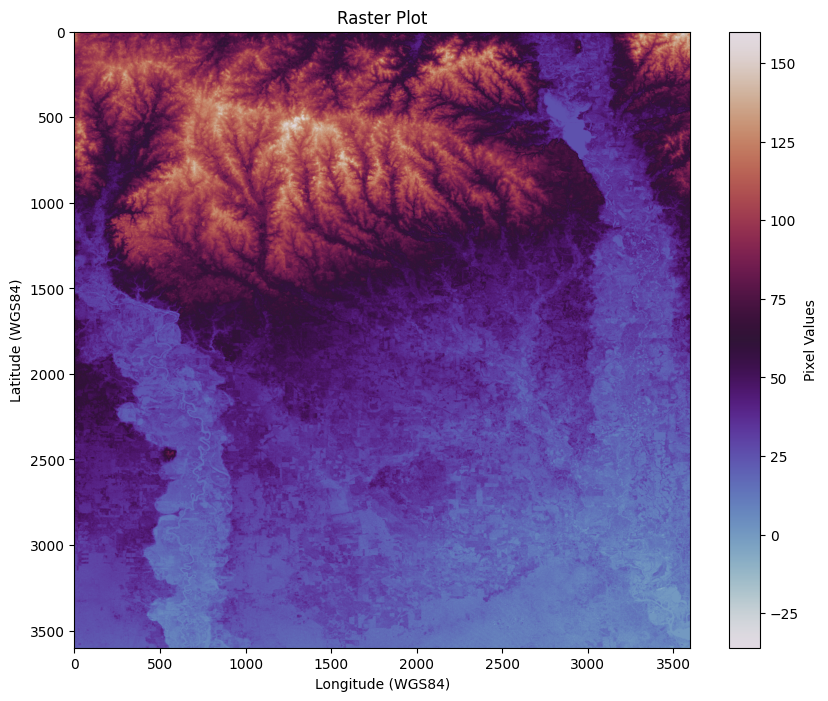

In [58]:
plt.figure(figsize=(10, 8))
plt.imshow(data, cmap = 'twilight') #Adjust the colormap as needed
plt.colorbar(label = 'Pixel Values')
plt.xlabel('Longitude (WGS84)')
plt.ylabel('Latitude (WGS84)')
plt.title('Raster Plot')
plt.show()

**This code clips a Digital Elevation Model (DEM) to the boundary of Lumberton, TX, using a GeoPackage of the city's boundary. It checks and aligns the coordinate reference system (CRS) of the city boundary and the DEM. The DEM is then clipped to the city boundary, and the output is saved as a new raster file. The clipped DEM is visualized with a custom terrain color map, masking out nodata values, and displaying a color bar for elevation. The final plot shows the elevation data inside the city of Lumberton.**

C:\Users\Sushant\AppData\Local\ipykernel_12064\925679812.py:15: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geo = gdf.geometry.unary_union  # Combine all geometries into a single multi-geometry (union of city boundaries)


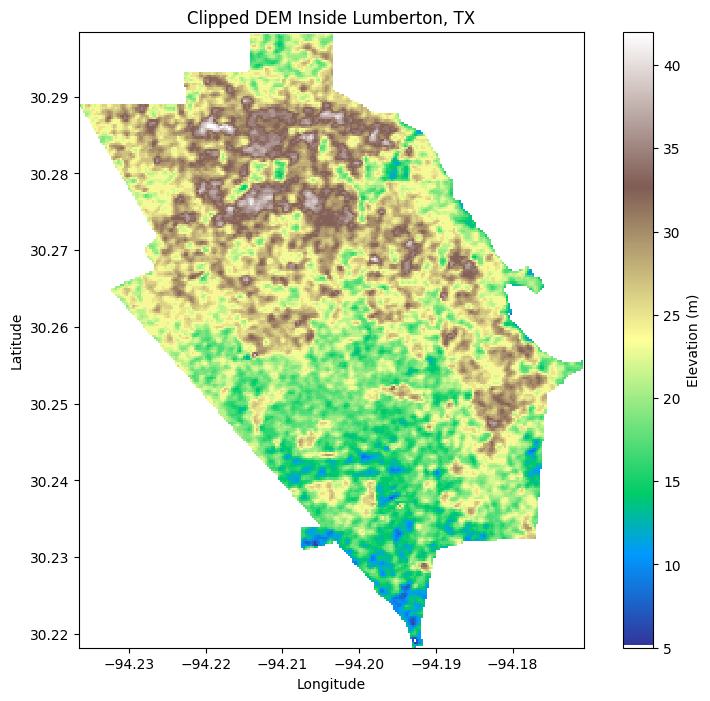

In [73]:
# Load the GeoDataFrame (city boundary from GeoPackage)
gpk_path = 'LumbertonCity.gpkg'  
gdf = gpd.read_file(gpk_path)  # Read the GeoPackage file into a GeoDataFrame

# Check if the CRS of the GeoDataFrame and the raster match
with rasterio.open('mosaic_output.tif') as src:  # Open the DEM file
    if gdf.crs != src.crs:  # If CRS of the GeoDataFrame doesn't match the raster's CRS
        gdf = gdf.to_crs(src.crs)  # Reproject the GeoDataFrame to match the raster's CRS

# Set the path to the DEM raster file
raster_path = 'mosaic_output.tif'  # Replace with your DEM file path

# Open the raster file and perform clipping
with rasterio.open(raster_path) as src:  # Open the DEM raster file
    geo = gdf.geometry.unary_union  # Combine all geometries into a single multi-geometry (union of city boundaries)
    
    # Mask the raster using the city boundary geometry, cropping the raster to the city extent
    out_image, out_transform = mask(src, [geo], crop=True, nodata=-9999)  # 'nodata=-9999' defines areas where data is missing
    
    # Copy the metadata of the raster to update for the new clipped raster
    out_metadata = src.profile.copy()
    
    # Update metadata to reflect the size and transform of the new clipped raster
    out_metadata.update({
        "height": out_image.shape[1],  # Set the new height of the raster
        "width": out_image.shape[2],   # Set the new width of the raster
        "transform": out_transform,    # Set the new affine transform
        "nodata": -9999                # Set the nodata value to -9999
    })
    
    # Define the path to save the clipped raster
    clipped_raster_path = "clipped_dem_inside_lumberton.tif"
    
    # Write the clipped raster to a new file
    with rasterio.open(clipped_raster_path, 'w', **out_metadata) as dest:
        dest.write(out_image)  # Write the clipped image to the file

# Prepare the data for plotting
data = out_image[0]  # Extract the first (and likely only) band of the DEM raster

# Mask out the nodata values to avoid plotting them as part of the raster (replace -9999 with NaN)
data_masked = np.where(data == -9999, np.nan, data)  # Mask the nodata areas

# Create a custom color map for better visualization of the terrain
terrain_cmap = plt.cm.terrain(np.linspace(0, 1, 256))  # Use a predefined terrain color map
terrain_cmap[0, :] = [1, 1, 1, 1]  # Make nodata values (0) white, so they don't interfere with the color map
custom_cmap = ListedColormap(terrain_cmap)  # Create a custom colormap with the modified terrain map

# Calculate the extent of the raster using the affine transform
min_x, min_y = out_transform * (0, data.shape[0])  # Get the coordinates for the bottom-left corner of the image
max_x, max_y = out_transform * (data.shape[1], 0)  # Get the coordinates for the top-right corner of the image

# Plot the clipped DEM data
plt.figure(figsize=(10, 8))  # Set the figure size for the plot
plt.imshow(data_masked, cmap=custom_cmap, extent=(min_x, max_x, min_y, max_y), interpolation="none")  # Display the image
plt.colorbar(label='Elevation (m)')  # Add a color bar with a label showing the elevation units
plt.title('Clipped DEM Inside Lumberton, TX')  # Set the plot title
plt.xlabel('Longitude')  # Label the x-axis
plt.ylabel('Latitude')  # Label the y-axis
plt.show()  # Show the plot

**This code identifies the lowest elevation point and the lowest positive elevation in a clipped DEM. It masks out nodata values (`-9999`), finds the indices of the lowest points, converts them to geospatial coordinates using the affine transform, and prints the lowest elevation with its coordinates.**

In [78]:
# Assuming 'data' contains the DEM values, 'out_transform' is the affine transform, 
# and the raster has been loaded and clipped as described in the previous steps.

# Mask the nodata values in the DEM (assuming -9999 is the nodata value)
masked_data = np.ma.masked_equal(data, -9999)  # Mask the nodata value (-9999)

# Find the indices of the lowest elevation point (ignoring nodata)
row, col = np.unravel_index(np.argmin(masked_data), data.shape)

# Convert the row and column indices to geospatial coordinates using the affine transform
lowest_point_coords = rasterio.transform.xy(out_transform, row, col, offset='center')

# Mask values less than or equal to 0 to focus on positive elevations
masked_data_above_zero = np.ma.masked_less_equal(data, 0)

# Find the indices of the lowest point above 0 (ignoring nodata and values <= 0)
row_above_zero, col_above_zero = np.unravel_index(np.argmin(masked_data_above_zero), data.shape)

# Convert the row and column of the lowest point above 0 to geospatial coordinates
lowest_point_coords_above_zero = rasterio.transform.xy(out_transform, row_above_zero, col_above_zero, offset='center')

# Get the elevation values at those points
lowest_point = data[row, col]
lowest_point_above_zero = data[row_above_zero, col_above_zero]

# Print results
print(f"Lowest elevation is {lowest_point:.2f}m at {lowest_point_coords} ")

Lowest elevation is 5.00m at (-94.19277777777776, 30.219166666666663) 


**This code processes a DEM by filling small pits, larger depressions, and resolving flat areas to improve its accuracy for hydrological modeling. It uses a `Grid` object to read the DEM and apply these corrections.**

In [81]:
# Load the DEM data from a raster file using a Grid object
grid = Grid.from_raster('clipped_dem_inside_lumberton.tif')  # Create a Grid object from the DEM file
dem = grid.read_raster('clipped_dem_inside_lumberton.tif')  # Read the DEM data from the raster

# Condition DEM
# ----------------------
# 1. Fill pits in the DEM
pit_filled_dem = grid.fill_pits(dem)  # Fill small depressions (pits) in the DEM where the elevation is lower than its surroundings

# 2. Fill depressions in the DEM
flooded_dem = grid.fill_depressions(pit_filled_dem)  # Fill larger, more widespread depressions in the DEM that can cause inaccuracies

# 3. Resolve flats in the DEM
inflated_dem = grid.resolve_flats(flooded_dem)  # Resolve flat areas by slightly inflating them to ensure proper flow directions for hydrological modeling

**This code calculates the D8 flow directions for a DEM using a specified directional mapping (`dirmap`), which determines the flow direction for each cell in the terrain.**

In [82]:
# Determine D8 flow directions from DEM
# ----------------------
# Specify directional mapping
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
    
# Compute flow directions
# -------------------------------------
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

**This code calculates the **flow accumulation** for the DEM, which represents the amount of upstream area that drains into each cell. It uses the flow directions (`fdir`) and the same directional mapping (`dirmap`) to compute the accumulated flow for each cell in the terrain.**

In [83]:
# Calculate flow accumulation
# --------------------------
acc = grid.accumulation(fdir, dirmap=dirmap)

**This code generates a plot of flow accumulation on the DEM, using a logarithmic color scale (`cubehelix` colormap) to visualize the upstream cell accumulation. The plot includes axis labels, a color bar, and a title, with the layout adjusted for clarity.**

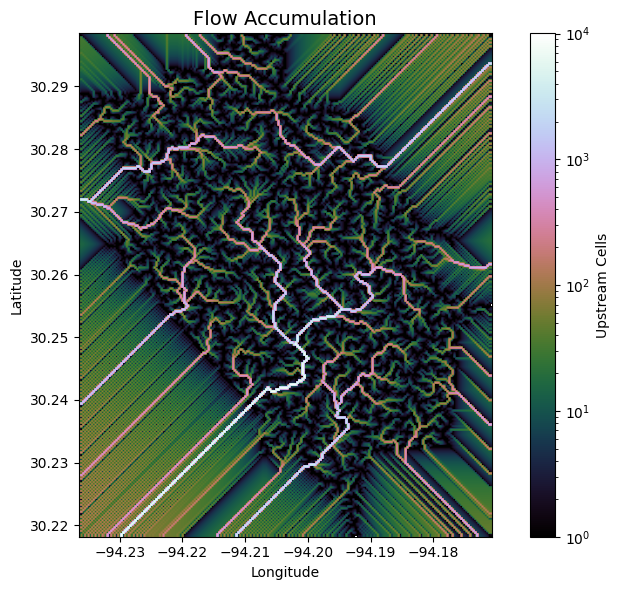

In [84]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(acc, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

**This code defines a catchment area by specifying a pour point, snapping it to a high flow accumulation cell, and using flow directions to delineate the catchment. The catchment is then clipped from the DEM for visualization.**

In [86]:
# Delineate a catchment
# ---------------------
# Specify pour point
x, y = -94.19277777777776, 30.219166666666663

# Snap pour point to high accumulation cell
x_snap, y_snap = grid.snap_to_mask(acc > 100, (x, y))

# Delineate the catchment
catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, 
                       xytype='coordinate')

# Crop and plot the catchment
# ---------------------------
# Clip the bounding box to the catchment
grid.clip_to(catch)
clipped_catch = grid.view(catch)

**This code plots the delineated catchment area on the DEM, using a grey colormap and labels for longitude and latitude. Areas outside the catchment are made transparent.**

Text(0.5, 1.0, 'Delineated Catchment')

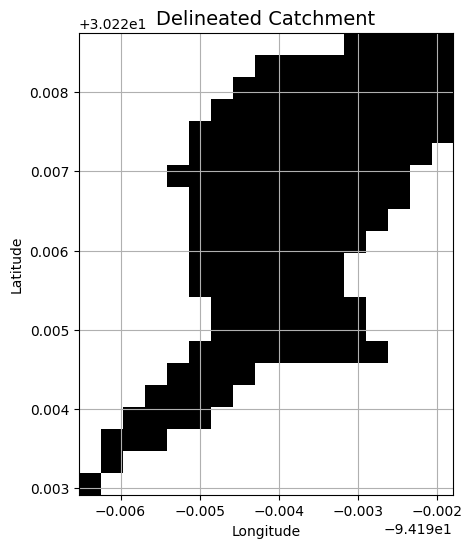

In [87]:
# Plot the catchment
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.grid('on', zorder=1)
im = ax.imshow(np.where(clipped_catch, clipped_catch, np.nan), extent=grid.extent,
               zorder=1, cmap='Greys_r')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Delineated Catchment', size=14)

**This code extracts the river network by identifying areas with high flow accumulation based on the flow directions.**

In [88]:
# Extract river network
# ---------------------
branches = grid.extract_river_network(fdir, acc > 100, dirmap=dirmap)

**This code plots the city boundary and river network, with the city boundary in blue and the river network overlaid, using equal aspect ratio for accurate scaling and a title "D8 channels."**

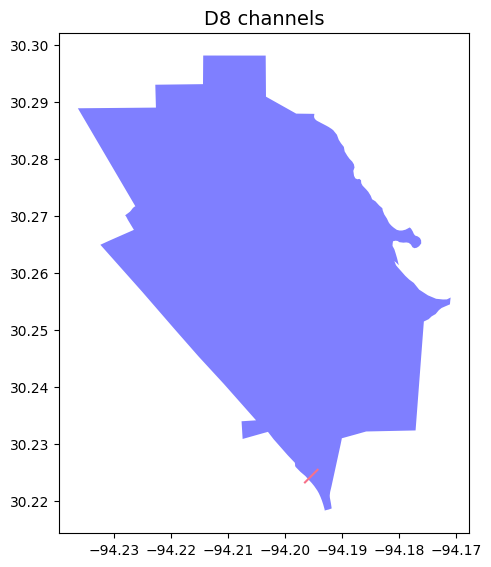

In [89]:
sns.set_palette('husl')
fig, ax = plt.subplots(figsize=(8.5,6.5))
gdf.plot(ax=ax, color='blue', alpha=0.5, label='Lumberton City')

ax.set_aspect('equal')

for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1])
    
_ = plt.title('D8 channels', size=14)

**This code calculates how far each cell is from the outlet based on the flow direction and the specified pour point.**

In [90]:
# Calculate distance to outlet from each cell
# -------------------------------------------
dist = grid.distance_to_outlet(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap,
                               xytype='coordinate')

**This code visualizes the distance from each cell to the outlet using a color map and provides a color bar for reference.**

Text(0.5, 1.0, 'Flow Distance')

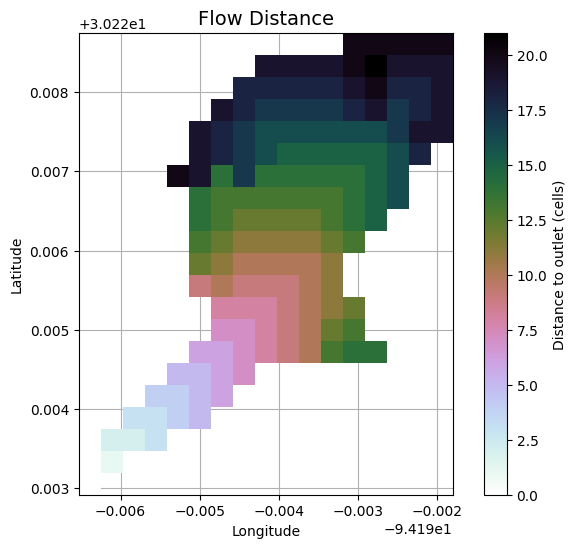

In [91]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(dist, extent=grid.extent, zorder=2,
               cmap='cubehelix_r')
plt.colorbar(im, ax=ax, label='Distance to outlet (cells)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow Distance', size=14)